In [5]:
# Import packages

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [10]:
args = {
    'dataset_folder': '/disk/xray0/tl3/repos/wf-studies/WFE_res/dataset/',
    #'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_009_wfeRes_4096.npy',
    #'train_dataset_file': 'train_Euclid_res_3000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_009_wfeRes_4096.npy',
    #'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    #'pupil_diameter': 128,
    'n_bins_lda':20,
    #'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'/disk/xray0/tl3/repos/wf-studies/WFE_res/wf-outputs/chkp/chkp_callback_poly_wfe_study_id009_256_benchmark_bis_1_cycle2',
    #'chkp_save_path':'../../more_stars/wf-outputs/chkp/3000_stars/chkp_callback_poly_full_poly_3000_stars_cycle2',
}

In [11]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

Zernike cube:
(15, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [12]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

In [28]:
len(z_coeffs)

15

In [13]:
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )


weights_paths = args['chkp_save_path']

# Load the model's weights
tf_semiparam_field.load_weights(weights_paths)

# Generate WFE

In [14]:
# Select any star from the 2000 test stars
test_star = 23

test_dataset = np.load(args['dataset_folder']+args['test_dataset_file'], allow_pickle=True)[()]
pos = test_dataset['positions'][test_star:test_star+1,:]

test_SEDs = test_dataset['SEDs']

In [15]:
# Ground truth WFE and WFE proyection on first 15 zernikes
param_opd_maps_GT = tf.tensordot(tf_zernike_cube_gt, tf.constant(test_dataset['zernike_coef'][test_star,:,0],dtype=tf.float32), axes=[0,0])
param_opd_maps_GT_low_Z = tf.tensordot(tf_zernike_cube, tf.constant(test_dataset['zernike_coef'][test_star,:args['n_zernikes'],0],dtype=tf.float32), axes=[0,0])

# Non parametric WFE
nonparam_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)
# Parametric WFE
zernike_coeffs = tf_semiparam_field.tf_poly_Z_field(pos)
param_opd_maps = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs)
# Total WFE
opd_maps = param_opd_maps + nonparam_opd_maps

2023-06-02 12:51:43.911066: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


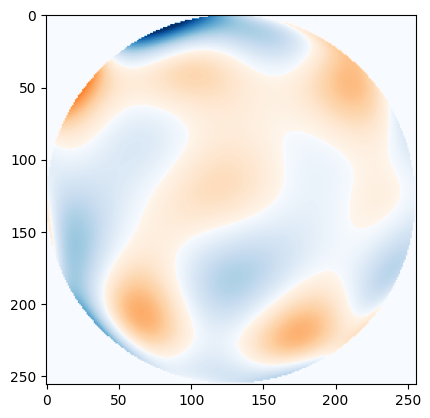

In [16]:
vmax=0.5
plt.imshow(param_opd_maps_GT, cmap=newcmp, vmax=vmax, vmin=-vmax)

### Zernikes

In [17]:
tf_obscurations_opd = tf.convert_to_tensor(obscurations, dtype=tf.float32)

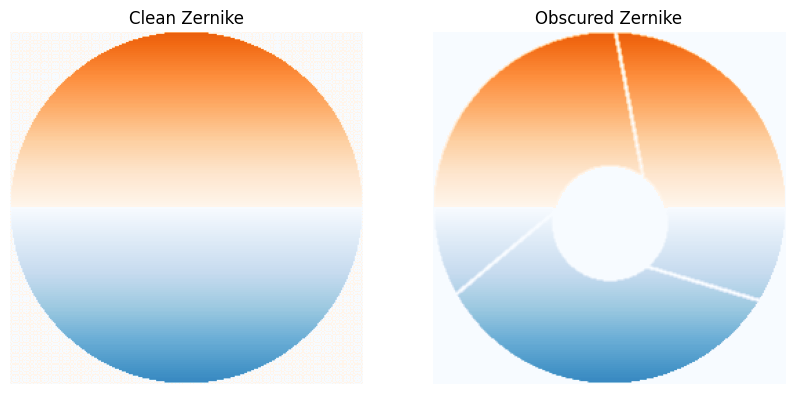

In [18]:
zernike_clean = [tf_zernike_cube_gt[i,:,:] for i in range(args['gt_n_zernikes'])]
zernike_obsc  = [zk * tf_obscurations_opd for zk in zernike_clean]

vmax=3
im, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(zernike_clean[2], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0].axis('off')
ax[0].set_title('Clean Zernike')
ax[1].imshow(zernike_obsc[2], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1].axis('off')
ax[1].set_title('Obscured Zernike')
plt.show()

### Proyections

In [19]:
n_pix_zernike = wf_utils.PI_zernikes(tf_zernike_cube[0,:,:],tf_zernike_cube[0,:,:])

In [20]:
delta_proj = np.zeros((args['gt_n_zernikes'],args['gt_n_zernikes']))
cross_proj = np.zeros((args['gt_n_zernikes'],args['gt_n_zernikes']))

for i, zk_clean in enumerate(zernike_clean):
    for j, zk_obsc in enumerate(zernike_obsc):
        delta_proj[i,j] = wf_utils.PI_zernikes(zk_clean,zk_obsc,n_pix_zernike)
        cross_proj[i,j] = wf_utils.PI_zernikes(zernike_clean[i],zernike_clean[j],n_pix_zernike)

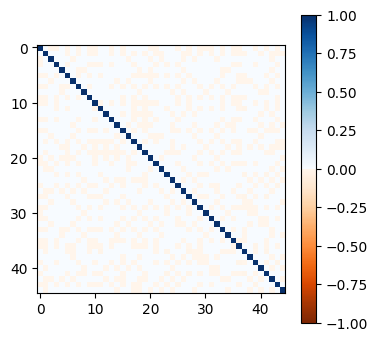

In [70]:
vmax = np.max(np.abs(cross_proj))
plt.figure(figsize=(4,4))
plt.imshow(cross_proj, cmap=newcmp,vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()


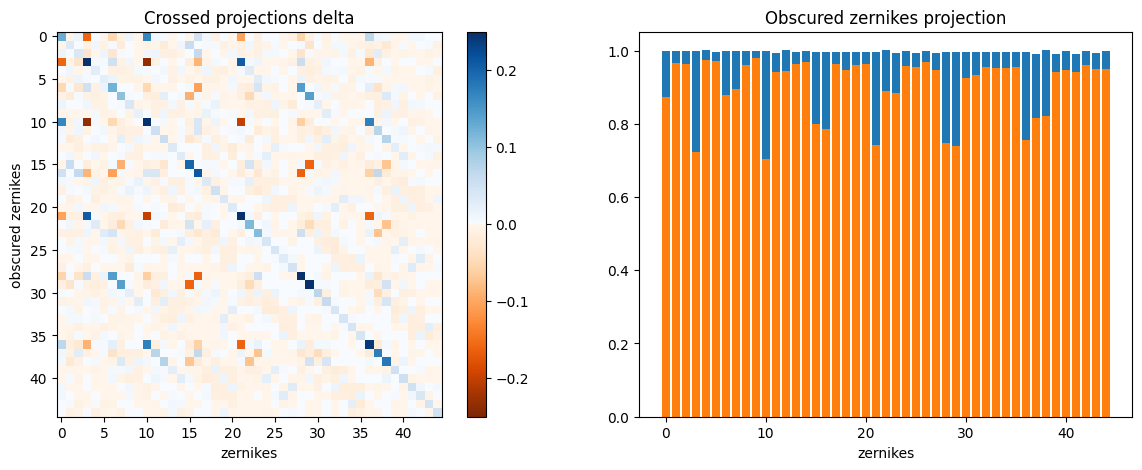

In [21]:
vmax=0.25
im, ax = plt.subplots(1,2,figsize=(14,5))

fig = ax[0].imshow(cross_proj - delta_proj, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar(fig, ax=ax[0])
ax[0].set_title('Crossed projections delta')
ax[0].set_xlabel('zernikes')
ax[0].set_ylabel('obscured zernikes')
ax[1].bar(np.array(range(args['gt_n_zernikes'])),np.diag(cross_proj), label='Norm')
ax[1].bar(np.array(range(args['gt_n_zernikes'])),np.diag(delta_proj), label='Projection')
ax[1].set_xlabel('zernikes')
#ax[1].legend(loc=(0.67,0.05))
ax[1].set_title('Obscured zernikes projection')

plt.show()

# Project noise

In [24]:
noise_map_clean = tf.random.normal(zernike_clean[0].shape, mean=0, stddev=0.1)*zernike_clean[0]
noise_map_obsc = noise_map_clean * tf_obscurations_opd

clean_proj_noise = np.zeros((args['gt_n_zernikes'],1))
obsc_proj_noise = np.zeros((args['gt_n_zernikes'],1))

for i, zk_clean in enumerate(zernike_clean):
    clean_proj_noise[i] = wf_utils.PI_zernikes(zk_clean, noise_map_clean, n_pix_zernike)
    obsc_proj_noise[i] = wf_utils.PI_zernikes(zk_clean, noise_map_obsc, n_pix_zernike)

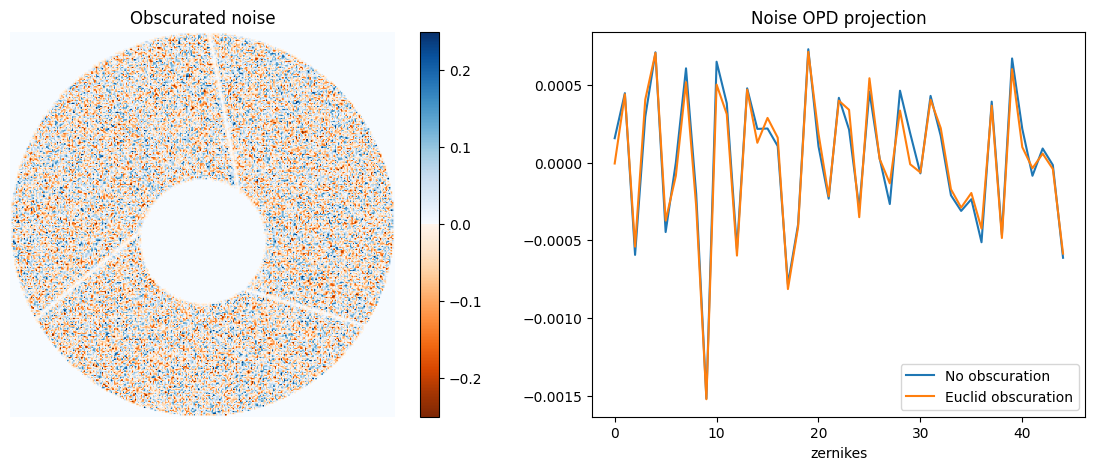

In [25]:
vmax=0.25
im, ax = plt.subplots(1,2,figsize=(14,5))

fig = ax[0].imshow(noise_map_obsc, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar(fig, ax=ax[0])
ax[0].set_title('Obscurated noise')
ax[0].axis('off')
ax[1].plot(clean_proj_noise, label='No obscuration')
ax[1].plot(obsc_proj_noise, label='Euclid obscuration')
ax[1].set_xlabel('zernikes')
ax[1].legend()
ax[1].set_title('Noise OPD projection')

plt.show()

# Project random high Zernikes

In [78]:
highZ_GT_order = 60


# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=highZ_GT_order, wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)


zernike_highZ_GT_clean = [tf_zernike_cube_gt[i,:,:] for i in range(highZ_GT_order)]

zernike_highZ_GT_obsc  = [zk * tf_obscurations_opd for zk in zernike_highZ_GT_clean]


Ground truth Zernike cube:
(60, 256, 256)


In [56]:
highZ_order = 45

# Generate Zernike maps
zernikes_highZ = wf_utils.zernike_generator(
    n_zernikes=highZ_order, wfe_dim=args['pupil_diameter']
)

# Prepare np input
simPSF_np_highZ = SimPSFToolkit(
    zernikes_highZ,
    max_order=highZ_order,
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np_highZ.gen_random_Z_coeffs(max_order=highZ_order)
z_coeffs = simPSF_np_highZ.normalize_zernikes(simPSF_np_highZ.get_z_coeffs(), simPSF_np_highZ.max_wfe_rms)
simPSF_np_highZ.set_z_coeffs(z_coeffs)
simPSF_np_highZ.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)


In [57]:
opd_higZ = np.nan_to_num(simPSF_np_highZ.opd, copy=True, nan=0.0)
tf_opd_higZ = tf.convert_to_tensor(opd_higZ, dtype=tf.float32)

tf_opd_higZ_obsc = tf.identity(tf_opd_higZ) * tf_obscurations_opd


In [60]:
clean_proj_noise = np.zeros((highZ_GT_order, 1))
obsc_proj_noise = np.zeros((highZ_GT_order, 1))

for i, zk_clean in enumerate(zernike_highZ_GT_clean):
    clean_proj_noise[i] = wf_utils.PI_zernikes(zk_clean, tf_opd_higZ, n_pix_zernike)
    obsc_proj_noise[i] = wf_utils.PI_zernikes(zk_clean, tf_opd_higZ_obsc, n_pix_zernike)


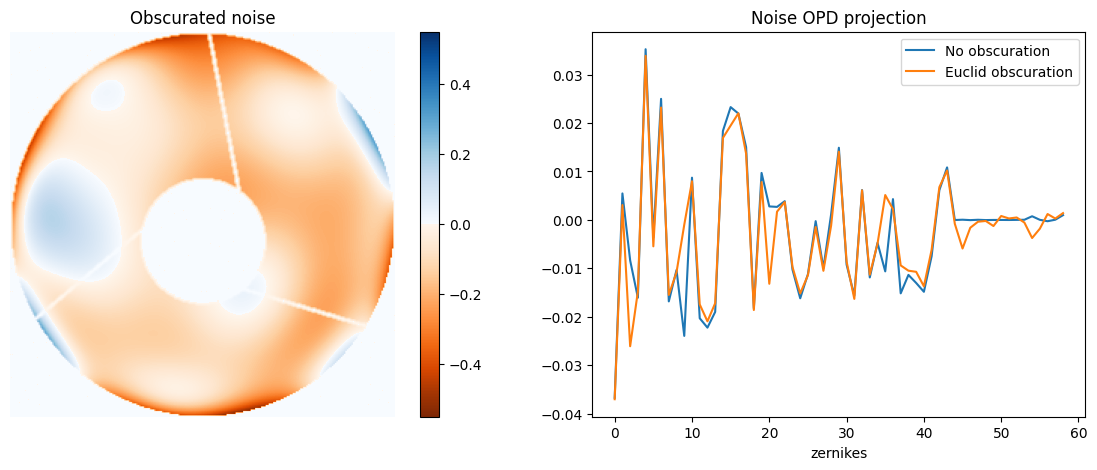

In [67]:
vmax=0.55
im, ax = plt.subplots(1,2,figsize=(14,5))

fig = ax[0].imshow(tf_opd_higZ_obsc, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar(fig, ax=ax[0])
ax[0].set_title('Obscurated noise')
ax[0].axis('off')
ax[1].plot(clean_proj_noise[1:], label='No obscuration')
ax[1].plot(obsc_proj_noise[1:], label='Euclid obscuration')
ax[1].set_xlabel('zernikes')
ax[1].legend()
ax[1].set_title('Noise OPD projection')

plt.show()


In [82]:
delta_proj = np.zeros((highZ_GT_order, highZ_GT_order))
cross_proj = np.zeros((highZ_GT_order, highZ_GT_order))

for i, zk_clean in enumerate(zernike_highZ_GT_clean):
    for j, zk_obsc in enumerate(zernike_highZ_GT_obsc):
        cross_proj[i,j] = wf_utils.PI_zernikes(zk_clean, zk_obsc, n_pix_zernike)
        delta_proj[i,j] = wf_utils.PI_zernikes(zernike_highZ_GT_clean[i], zernike_highZ_GT_clean[j], n_pix_zernike)



In [83]:
np.diag(delta_proj)

array([1.        , 0.99940373, 0.99940381, 0.99881389, 1.0008212 ,
       0.99679694, 0.99822879, 0.99822879, 0.99821601, 0.99821586,
       0.99765671, 0.99432285, 1.00097457, 0.99552526, 0.99972387,
       0.99709304, 0.99709304, 0.99707353, 0.99707337, 0.99703465,
       0.99703465, 0.99654905, 1.00113315, 0.99194198, 0.99937388,
       0.99363245, 0.99952159, 0.99337124, 0.99601714, 0.99601714,
       0.99599058, 0.99599043, 0.99593793, 0.99593785, 0.99585986,
       0.99585986, 0.99551225, 0.98969757, 1.00129678, 0.9918806 ,
       0.99902351, 0.99149296, 0.99926222, 0.99211816, 0.99843168,
       0.99502328, 0.9950232 , 0.99498938, 0.99498938, 0.9949221 ,
       0.9949221 , 0.99482215, 0.99482223, 0.99469151, 0.99469159,
       0.99456898, 1.00146209, 0.98763822, 0.998672  , 0.99031558])

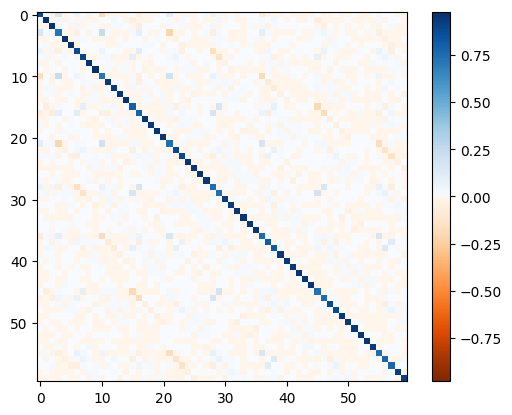

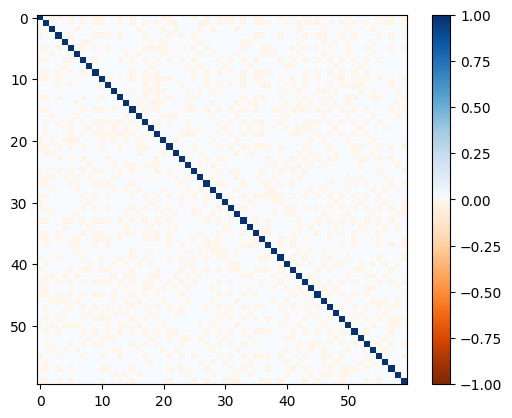

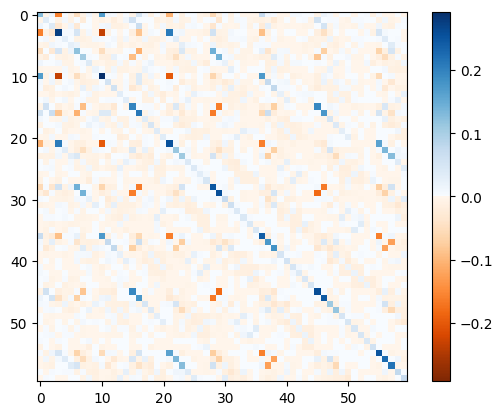

In [86]:
vmax = np.max(np.abs(cross_proj))
plt.figure()
plt.imshow(cross_proj, cmap=newcmp,vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()

vmax = np.max(np.abs(delta_proj))
plt.figure()
plt.imshow(delta_proj, cmap=newcmp,vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()

vmax = np.max(np.abs(delta_proj - cross_proj))
plt.figure()
plt.imshow(delta_proj - cross_proj, cmap=newcmp, vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.show()


45